1. Create conda env with GPU
2. Create data generator with augmentation
3. Create simple model
4. create advanced model with Bayesian Optimization for Hyperparameter tuning

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import glob
%reload_ext autoreload
%autoreload 2



Segmentation Models: using `keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [20]:
NUM_CLASSES = 34
IMAGE_SIZE = (256, 256, 3)

In [5]:
def display_batch_of_images(batch):
  import matplotlib.pyplot as plt

  for i in range(len(batch[0])):

    image = batch[0][i]

    # normalize to [0,1]
    image =  (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-9)

    segmentation = tf.math.argmax(batch[1][i], axis=-1) # undo to_categorical

    segmentation = tf.cast(segmentation, tf.float32)
    segmentation = tf.multiply((255.0 / NUM_CLASSES), segmentation)
    segmentation = segmentation / 255.0

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, vmin=0, vmax=1)
    plt.title('Ground Truth Segmentation')

    plt.show()

In [8]:
DATA_FOLDER = f"C:\dev\CompVisData"

In [41]:
import albumentations as A
from data_generator import SegmentationDataGenerator

BATCH_SIZE = 6


aug = A.Compose([
        A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.01),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.Blur(p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.2),
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1),
        A.RandomBrightnessContrast(p=1)
    ]
)

train_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/train_small/train/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/train_small/train/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
train_data_gen = train_data.get_data_generator()

val_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/val/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/val/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
val_data_gen = val_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 3904 images with 44 segmentations
Indexing Image files...
Indexing Segmentation files...
Loaded 8544 images with 30 segmentations


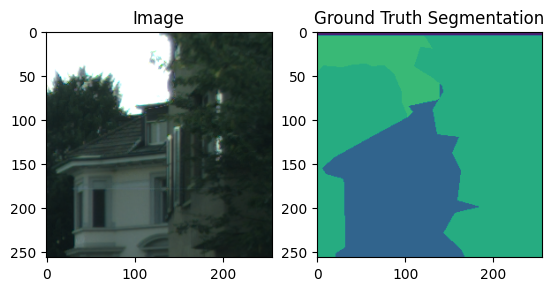

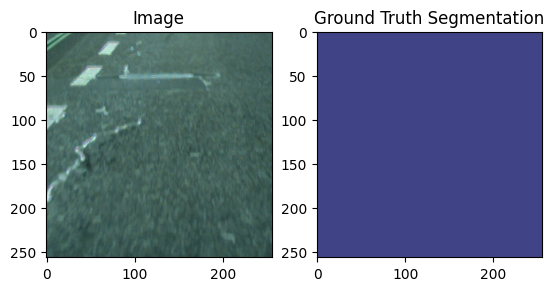

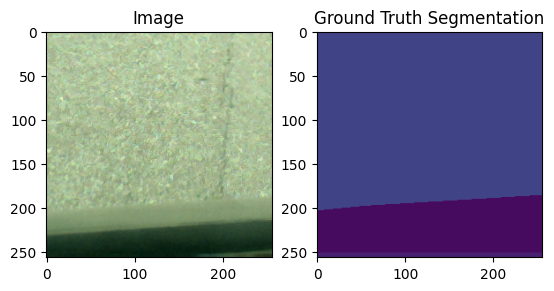

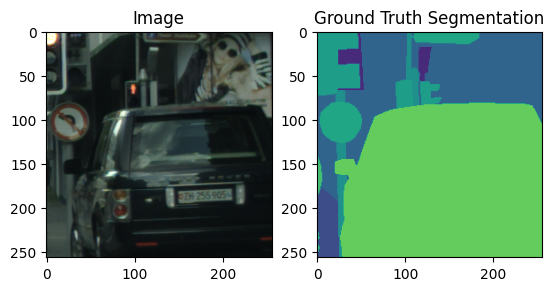

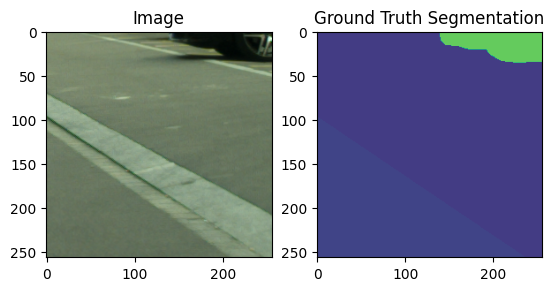

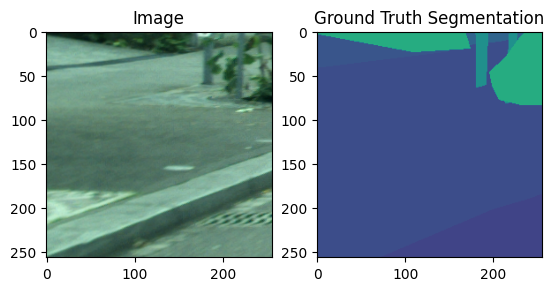

In [42]:
batch = train_data_gen.__next__()
display_batch_of_images(batch)

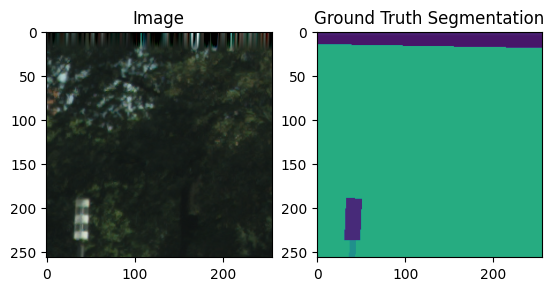

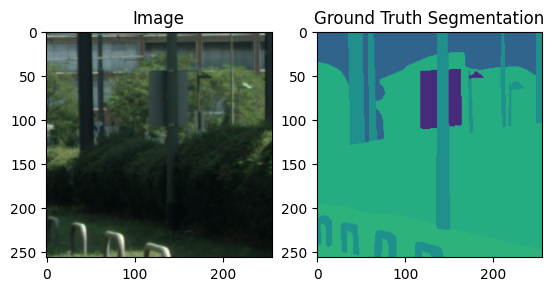

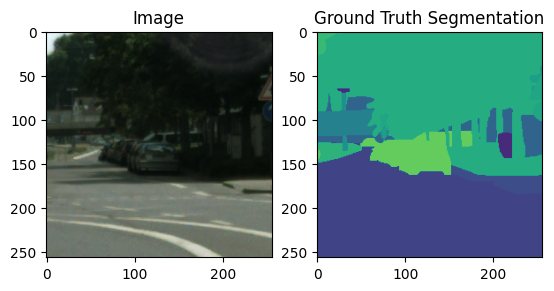

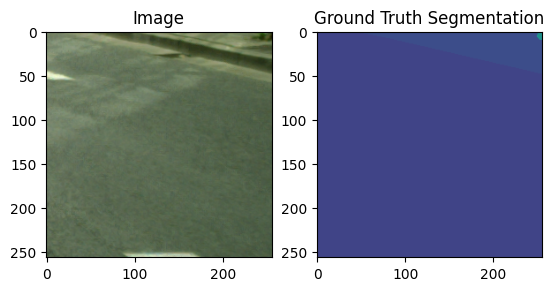

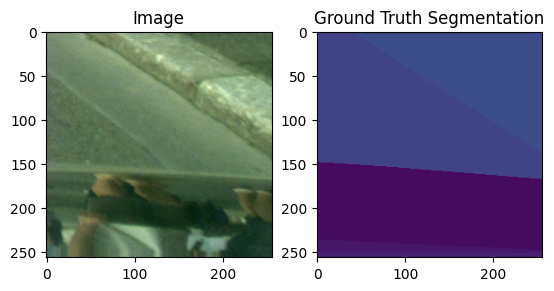

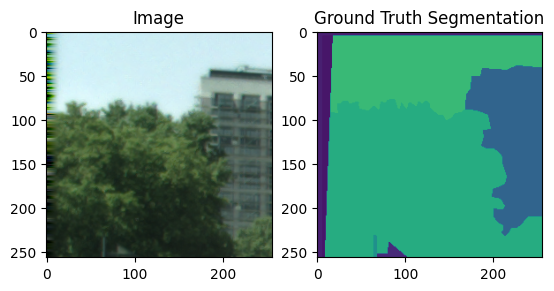

In [43]:
batch = val_data_gen.__next__()
display_batch_of_images(batch)

# Define Model

In [44]:
def fcn_simple_no_border(input_height:int, input_width:int, input_channels:int, num_classes:int) -> tf.keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = tf.keras.Sequential()
    
    # (used to define input shape on the first layers)
    model.add(tf.keras.layers.Layer(input_shape=(input_height , input_width, input_channels)))
    
    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))

    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))

    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=1, strides=1, padding='same', activation='relu'))

    model.add(tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    
    model.add(tf.keras.layers.Convolution2D(filters=num_classes, kernel_size=3, strides=(1, 1), padding='same', activation='softmax'))
    
    return model

In [45]:
model = fcn_simple_no_border(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], NUM_CLASSES)

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_5 (Layer)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 256, 256, 4)       112       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 4)       148       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 128, 128, 4)       148       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 4)         148       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 4)         20        
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 4)        

## Calculate Class weights for loss

In [47]:
x, y = train_data_gen.__next__()

print(x.shape)
print(y.shape)

(6, 256, 256, 3)
(6, 256, 256, 34)


In [48]:
_, y = train_data_gen.__next__()

total_values = y.shape[1] * y.shape[2] * y.shape[3]

class_counts = np.zeros(NUM_CLASSES)
n = 10

for _ in range(BATCH_SIZE*n):

    _, y = train_data_gen.__next__()

    #undo keras.to_categorical
    y = np.argmax(y, axis=-1)

    indexes = np.unique(y, return_counts=True)[0]
    counts = np.unique(y, return_counts=True)[1]
    for index, count in zip(indexes, counts):
        class_counts[index-1] += count

    
class_weights = np.asarray(class_counts)
class_weights = np.divide(class_weights, n*total_values)
class_weights = np.sum(class_weights) - class_weights
class_weights = np.divide(class_weights, np.sum(class_weights))
    
print(f"Class weights: {class_weights}")

Class weights: [0.02894109 0.03030303 0.02984357 0.02998043 0.03021244 0.03002533
 0.02042772 0.0281467  0.03021401 0.03030303 0.02403609 0.02995422
 0.03010293 0.03030303 0.03030303 0.03030303 0.03001806 0.03030058
 0.03023836 0.03021705 0.02576524 0.03009031 0.02940192 0.03003058
 0.03024941 0.02834357 0.03027426 0.03030182 0.03030303 0.03030303
 0.03005657 0.03014738 0.03025626 0.03030286]


In [49]:
_, y = train_data_gen.__next__()

In [50]:
y.shape

(6, 256, 256, 34)

In [51]:
dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss(
                                alpha = class_weights,
                                gamma = 2.0
                    )
total_loss = dice_loss + focal_loss

In [52]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_multilabel(y_true, y_pred, smooth=10e-6):
    dice = 0
    for index in range(NUM_CLASSES):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index], smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef_multilabel(y_true, y_pred)

In [53]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=NUM_CLASSES)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [54]:
# Define callbacks.
MODEL_NAME = "1"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "training/checkpoints/"+MODEL_NAME+"/checkpoints/epoch_{epoch}.keras",
    monitor='val_loss',
    save_best_only=True
)

In [55]:
metrics = [
        tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
    ]

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
)


model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

In [56]:
STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE

history = model.fit(x=train_data_gen, validation_data=val_data_gen, validation_steps=5, validation_batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, batch_size=BATCH_SIZE, epochs=50, callbacks=[checkpoint_cb])

Epoch 1/50
 64/650 [=>............................] - ETA: 27:45 - loss: 1.0025 - mean_io_u_2: 0.4853

KeyboardInterrupt: 